In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define data generators for training, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'data/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    'data/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'data/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (5,5), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (7,7), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=1, validation_data=val_generator)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model.save('trained_5_input_1.keras')

AttributeError: 'Sequential' object has no attribute 'load'

In [7]:
model_path = 'trained_5_input_1.keras'
model = tf.keras.models.load_model(model_path)

NameError: name 'tf' is not defined

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_TWILIGHT):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

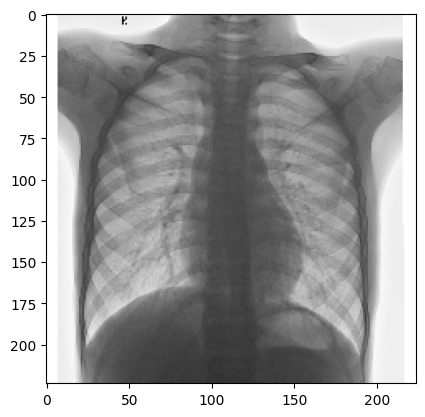

(1, 224, 224, 1)
1/1 [==============================] - 0s 62ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


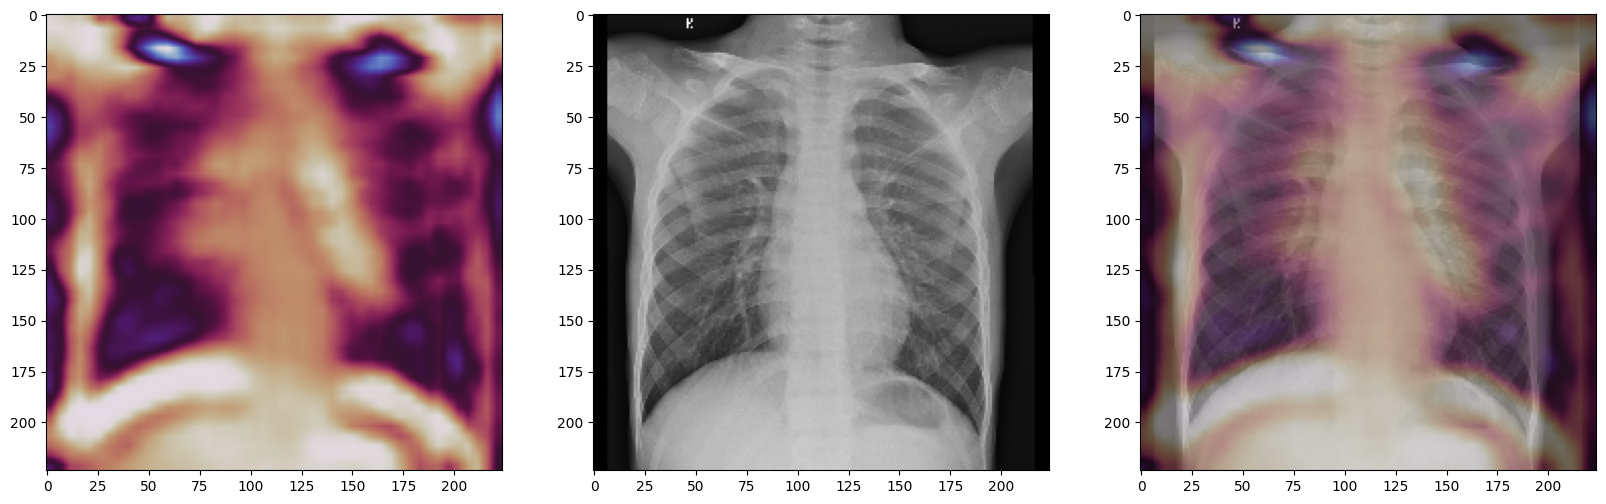

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0019-0001.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0019-0001.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

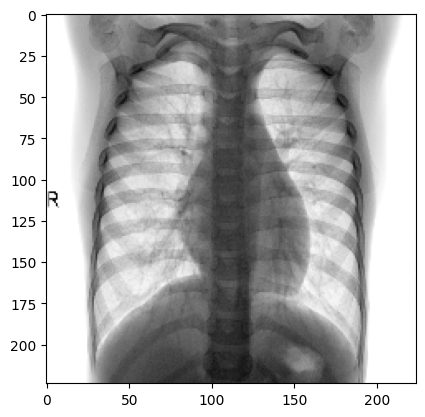

(1, 224, 224, 1)
1/1 [==============================] - 0s 118ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


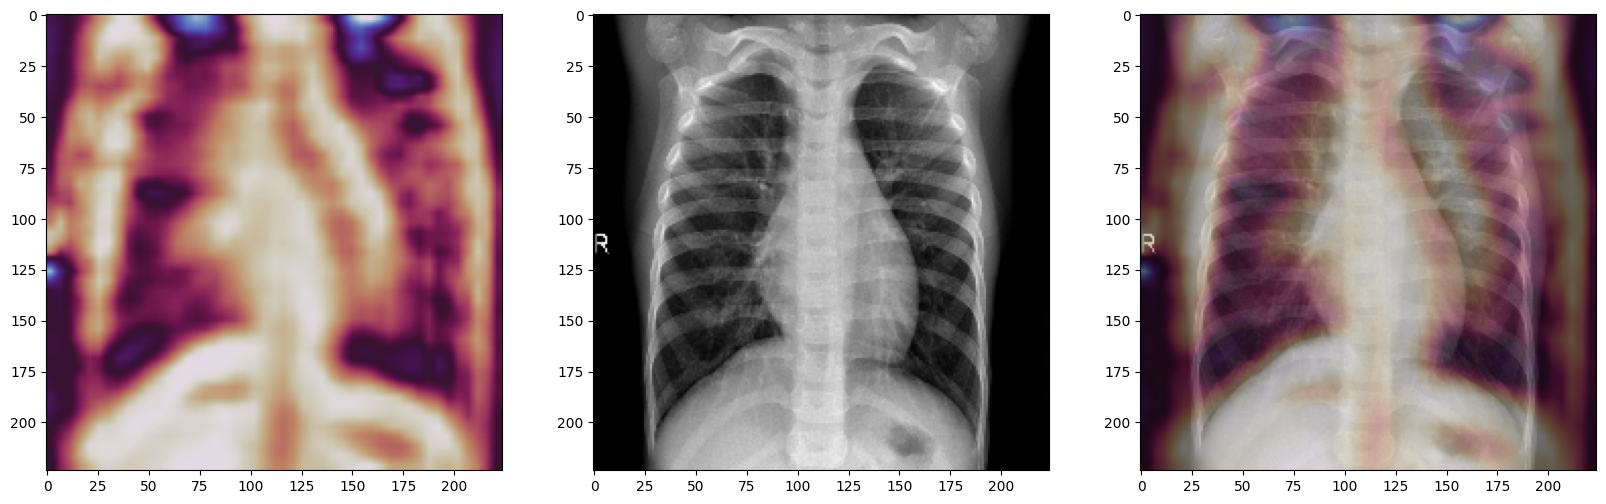

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0357-0001.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0357-0001.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

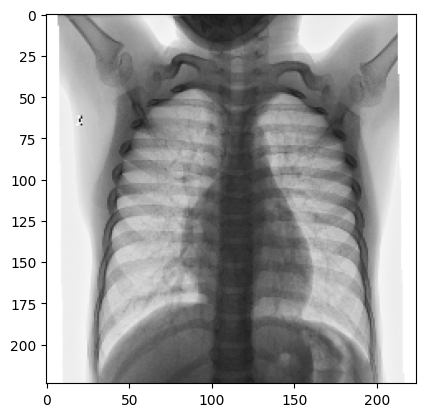

(1, 224, 224, 1)
1/1 [==============================] - 0s 97ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


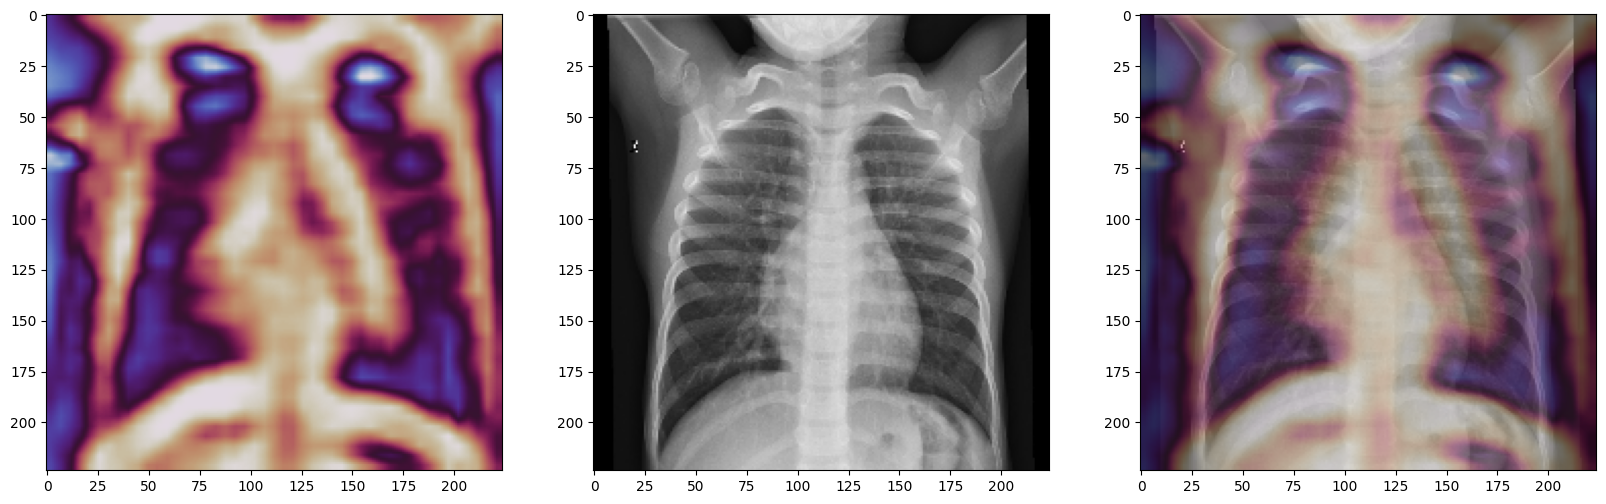

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0029-0001.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0029-0001.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

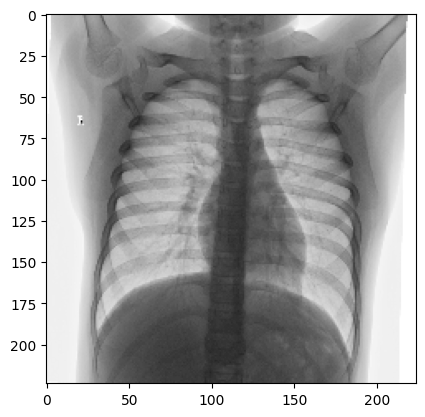

(1, 224, 224, 1)
1/1 [==============================] - 0s 87ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


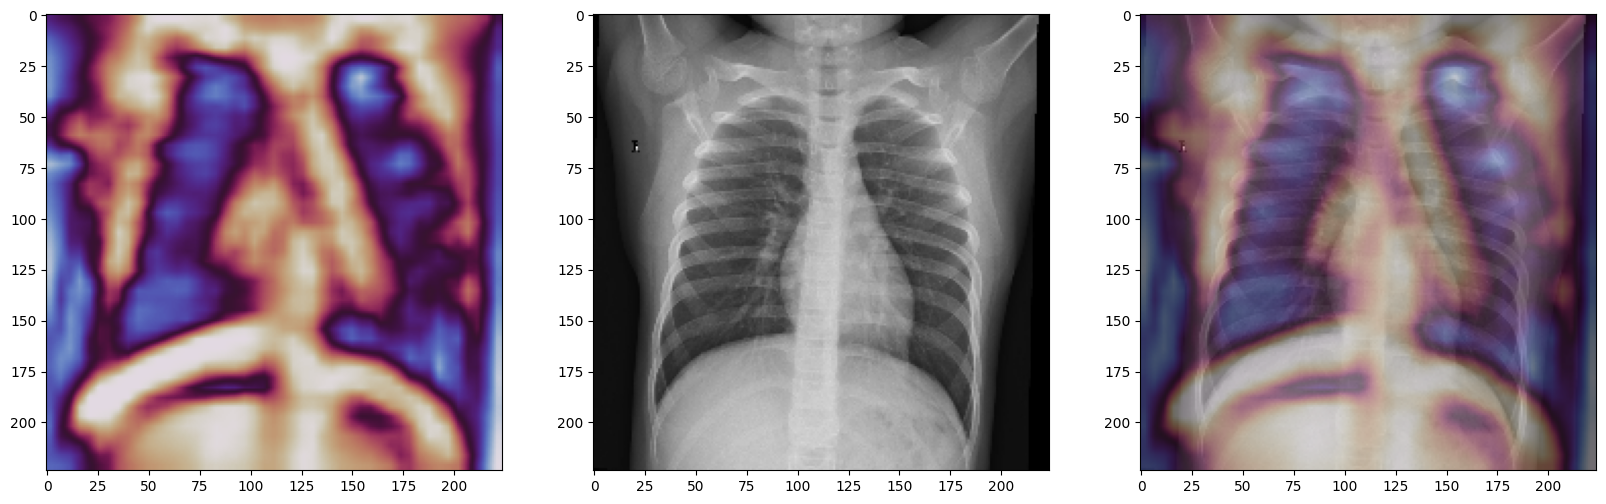

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0033-0001.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0033-0001.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

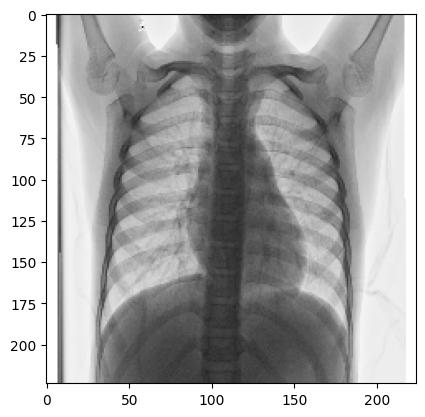

(1, 224, 224, 1)
1/1 [==============================] - 0s 113ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


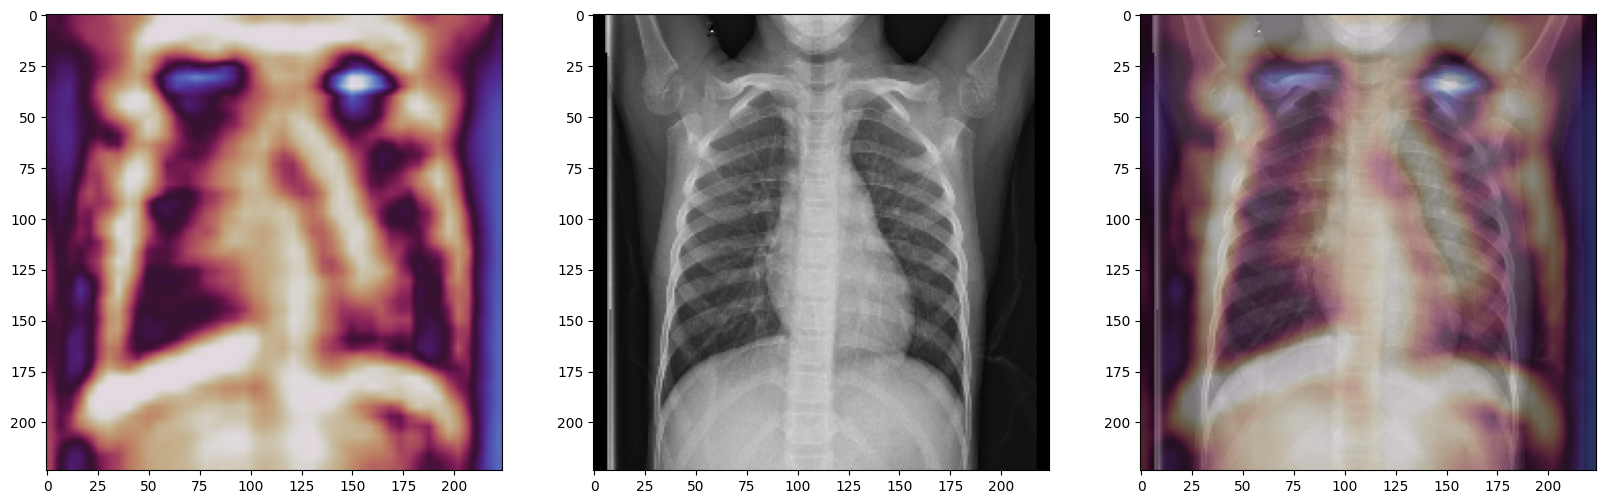

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0110-0001.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/NORMAL/NORMAL2-IM-0110-0001.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

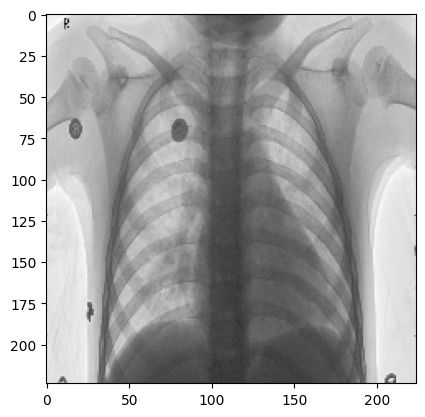

(1, 224, 224, 1)


In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person11_virus_38.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

In [ ]:
preds = model.predict(image)
i = np.argmax(preds[0])

1/1 [==============================] - 0s 59ms/step


In [ ]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

The last convolutional layer is: conv2d_13


In [ ]:
# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person11_virus_38.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(224, 224) (224, 224, 3)


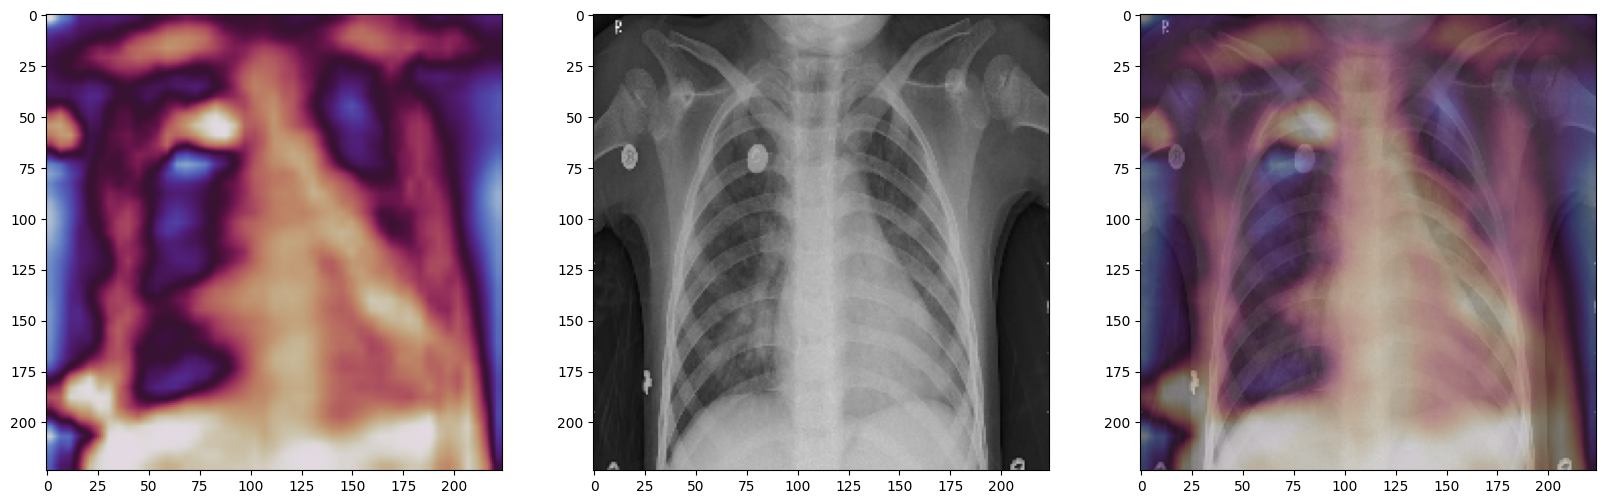

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

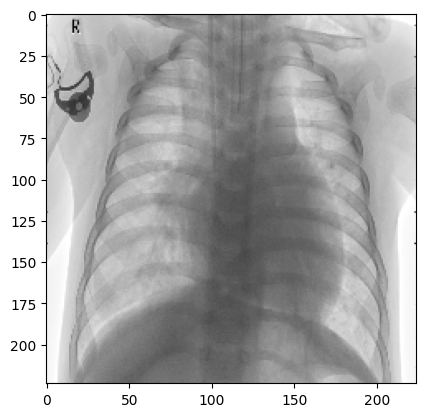

(1, 224, 224, 1)
1/1 [==============================] - 0s 55ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


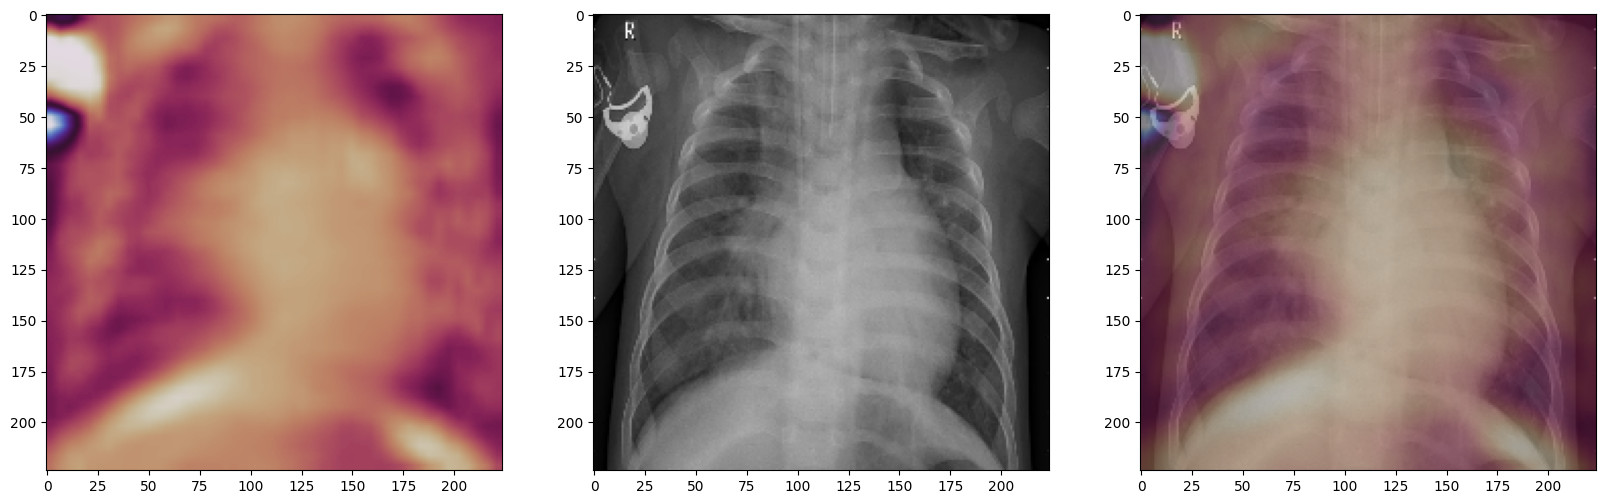

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person80_bacteria_391.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person80_bacteria_391.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

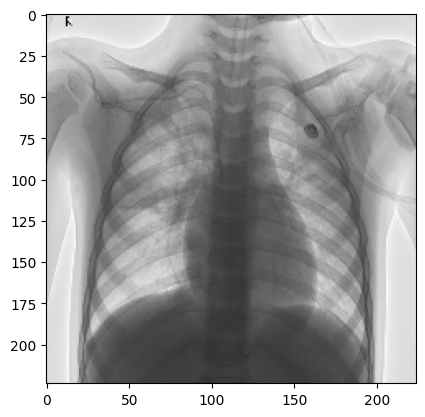

(1, 224, 224, 1)
1/1 [==============================] - 0s 56ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


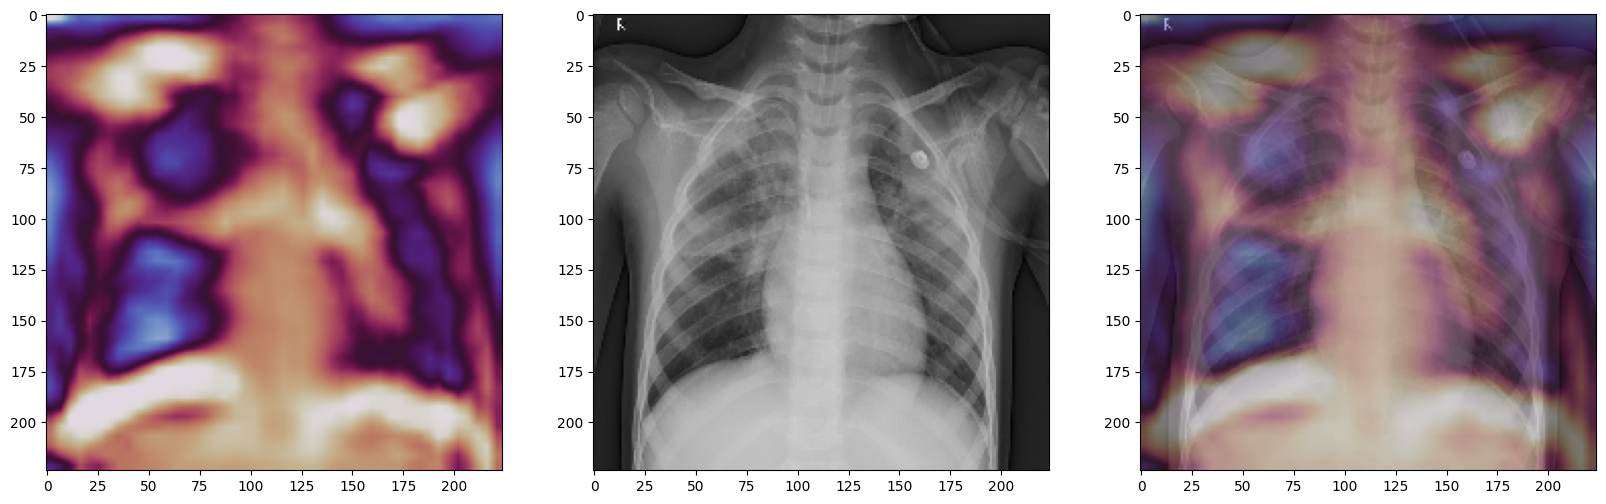

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person3_virus_17.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person3_virus_17.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

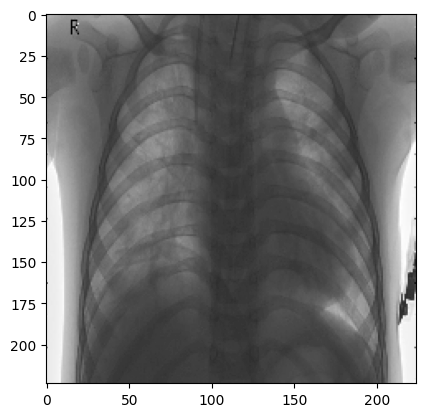

(1, 224, 224, 1)
1/1 [==============================] - 0s 94ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


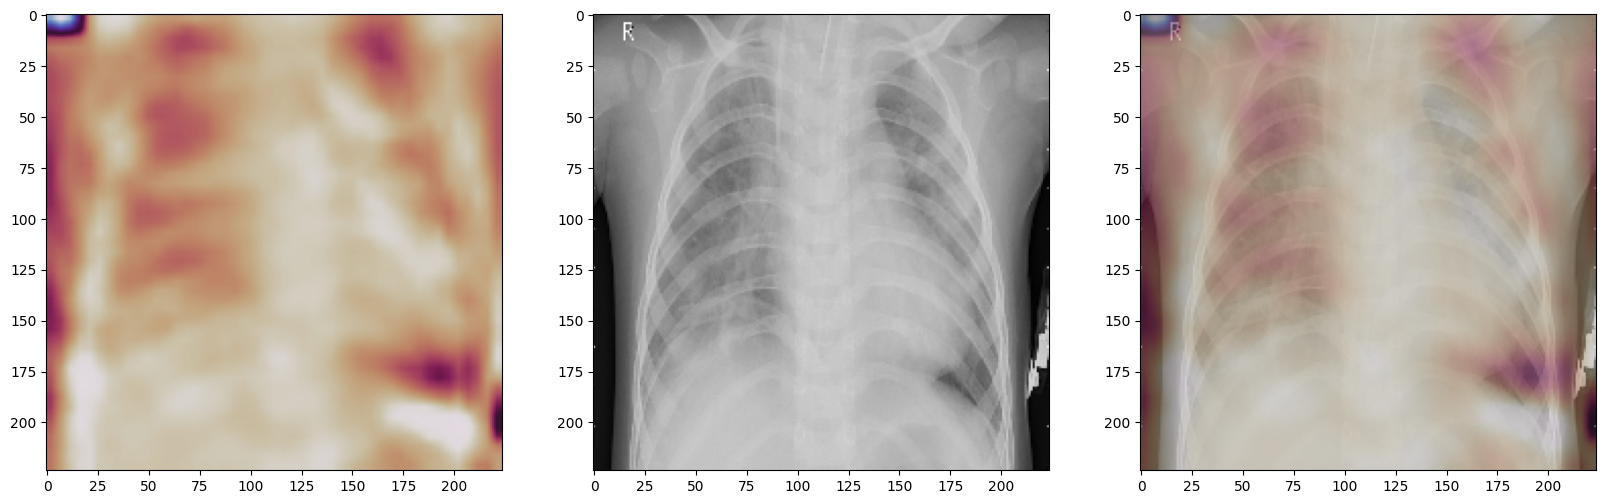

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person101_bacteria_483.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person101_bacteria_483.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

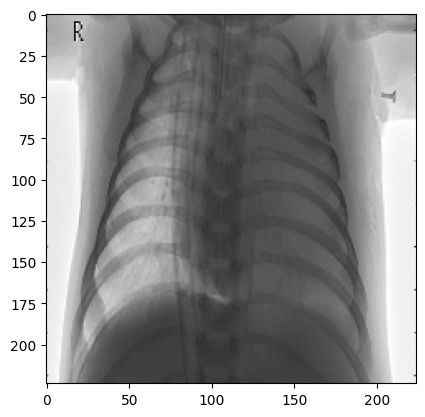

(1, 224, 224, 1)
1/1 [==============================] - 0s 175ms/step
The last convolutional layer is: conv2d_13
(224, 224) (224, 224, 3)


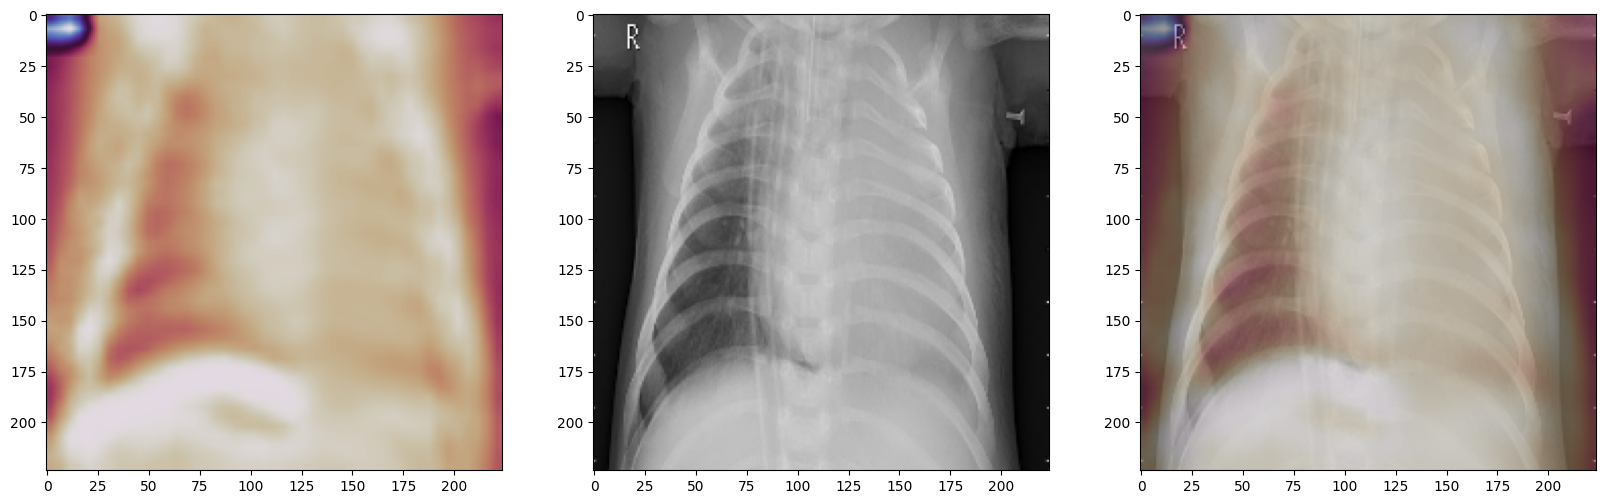

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person141_bacteria_670.jpeg', 0)
image = cv2.bitwise_not(image)          # ATTENTION
image = cv2.resize(image, (224, 224))

# checking how it looks
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape) # (1, 84, 84, 1)

preds = model.predict(image)
i = np.argmax(preds[0])

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None  # In case there is no convolutional layer

last_conv_layer_name = find_last_conv_layer(model)
print(f"The last convolutional layer is: {last_conv_layer_name}")

# `conv2d_19` - remember this, we talked about it earlier
icam = GradCAM(model, i, 'conv2d_13')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/My Drive/archive/chest_xray/test/PNEUMONIA/person141_bacteria_670.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)